In [1]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib

Data Preparation

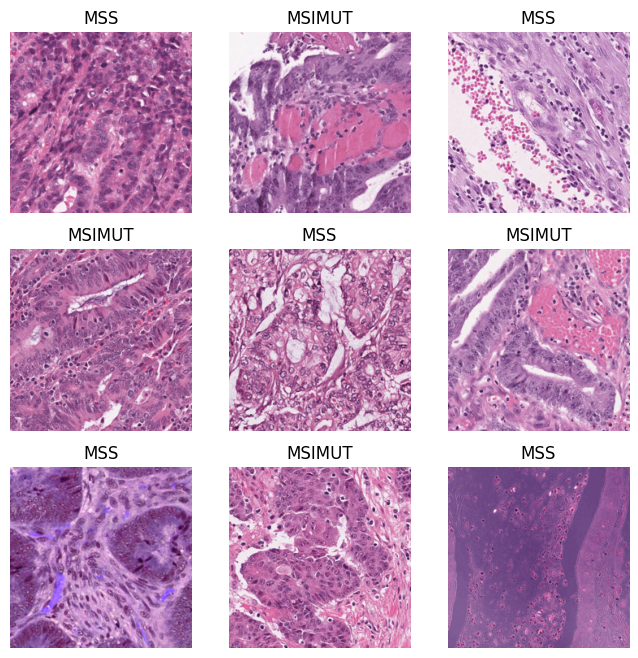

In [15]:
# Path to dataset
training_path = pathlib.Path("../dataset/training/")
mss = list(training_path.glob('MSS/*'))
msi = list(training_path.glob('MSIMUT/*'))

#Show examples of original images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, ax in enumerate(axes.flat):
    if(i % 2 == 0):
        img = PIL.Image.open(str(mss[i]))
        ax.imshow(img)
        ax.set_title("MSS")
        ax.axis('off')
    else:
        img = PIL.Image.open(str(msi[i]))
        ax.imshow(img)
        ax.set_title("MSIMUT")
        ax.axis('off')

# Show the grid of images
plt.show()

In [16]:
print(f"Number of MSIMUT Samples: {len(msi)}")
print(f"Number of MSS Samples: {len(mss)}")

Number of MSIMUT Samples: 30000
Number of MSS Samples: 30000


In [23]:
#Check if all images have the same resolution
resolution = set()
for image_file in msi:
    with Image.open(image_file) as img:
        resolution.add(img.size)
for image_file in mss:
    with Image.open(image_file) as img:
        resolution.add(img.size)
if len(resolution) == 1:
    print("All images have the same resolution:", resolution.pop())
else:
    print("Images have different resolutions:", resolution)

All images have the same resolution: (224, 224)


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
batch=32
img_height,img_width=224,224

#Data preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,) #Setup ratio between validation and training set 

#Create training and validation sets
train_ds = train_datagen.flow_from_directory(
    directory=training_path,
    target_size=(img_height,img_width),
    subset="training",
    batch_size=batch,
    class_mode='binary',
    seed=666
)

val_ds = train_datagen.flow_from_directory(
    directory=training_path,
    target_size=(img_height,img_width),
    subset="validation",
    batch_size=batch,
    class_mode='binary',
    seed=666
)

Found 48000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


In [6]:
print("Names of the classes: " + str(train_ds.class_indices))

Names of the classes: {'MSIMUT': 0, 'MSS': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


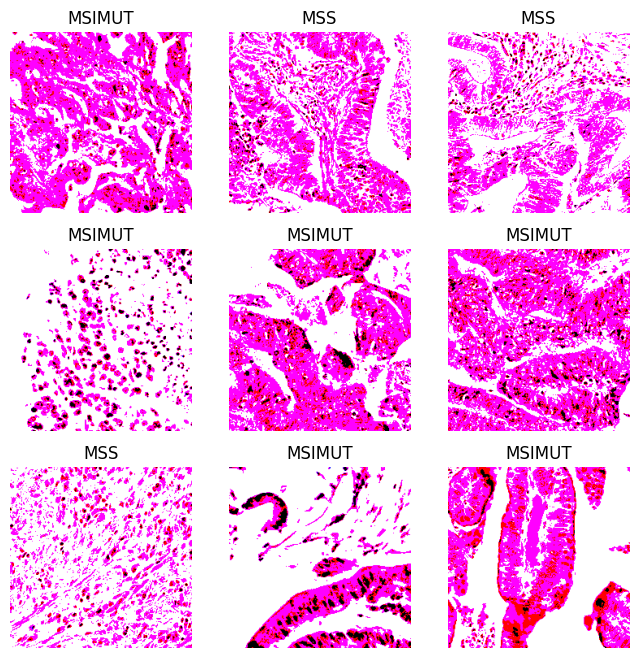

In [13]:
#Images after Preprocessing
images, labels = next(train_ds)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    if(labels[i]==1):
        ax.set_title("MSS")
    else:
        ax.set_title("MSIMUT")
    ax.axis('off')
plt.show()

Classifier Training

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   classes=2,
                   weights='imagenet')
pretrained_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = pretrained_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.8)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.8)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
resnet_model = keras.Model(inputs, outputs)

resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer=keras.optimizers.Adam(),
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs=200
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

In [ ]:
resnet_model.save('../Feature Extraction models/resnet50_model_no_fine_tune', save_format="h5")

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Fine-tuning

In [5]:
resnet_model = keras.models.load_model('../Feature Extraction models/resnet50_model_no_fine_tune')

In [6]:
resnet_model.trainable = True
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                             

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 200
history_fine_tune = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
    )

Epoch 1/200
1500/1500 [==============================] - 830s 524ms/step - loss: 0.5723 - binary_accuracy: 0.7061 - val_loss: 0.5535 - val_binary_accuracy: 0.7568
Epoch 2/200
1500/1500 [==============================] - 620s 413ms/step - loss: 0.5565 - binary_accuracy: 0.7172 - val_loss: 0.5472 - val_binary_accuracy: 0.7613
Epoch 3/200
1500/1500 [==============================] - 622s 414ms/step - loss: 0.5445 - binary_accuracy: 0.7296 - val_loss: 0.5372 - val_binary_accuracy: 0.7736
Epoch 4/200
1500/1500 [==============================] - 617s 411ms/step - loss: 0.5357 - binary_accuracy: 0.7379 - val_loss: 0.5289 - val_binary_accuracy: 0.7832
Epoch 5/200
1500/1500 [==============================] - 621s 414ms/step - loss: 0.5247 - binary_accuracy: 0.7470 - val_loss: 0.5215 - val_binary_accuracy: 0.7877
Epoch 6/200
1500/1500 [==============================] - 616s 411ms/step - loss: 0.5121 - binary_accuracy: 0.7544 - val_loss: 0.5293 - val_binary_accuracy: 0.7794
Epoch 7/200
1500/1500 

In [8]:
resnet_model.save('../Feature Extraction models/resnet50_model', save_format="h5")

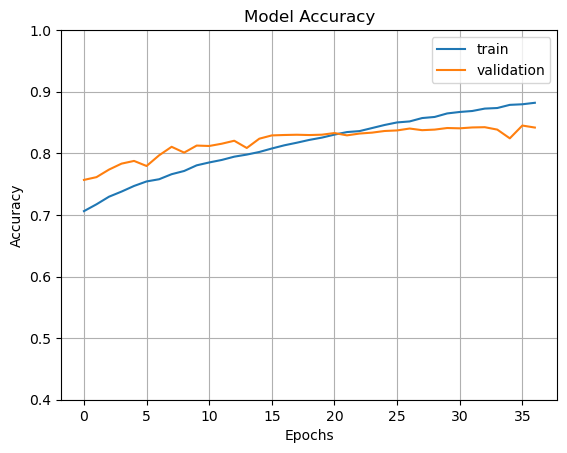

In [9]:
fig1 = plt.gcf()
plt.plot(history_fine_tune.history['binary_accuracy'])
plt.plot(history_fine_tune.history['val_binary_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     

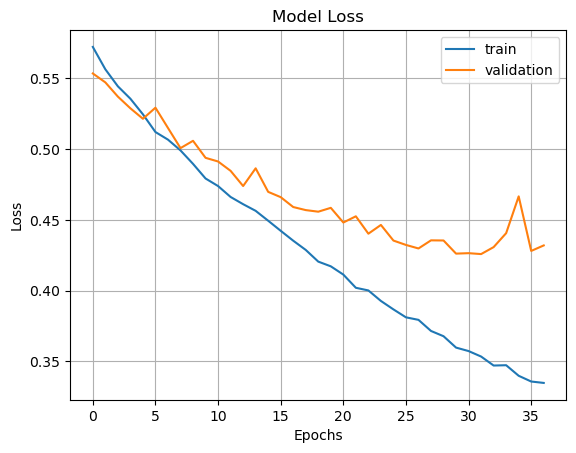

In [10]:
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()